In [34]:
# https://www.kaggle.com/datasets/crowdflower/twitter-airline-sentiment

In [35]:
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc

from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers 



In [36]:
np.random.seed(0)
tf.random.set_seed(0)

In [37]:
df = pd.read_csv(r'./dataSet/Twitter US Airline Sentiment/Tweets.csv')

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [39]:
df = df[['airline_sentiment', 'text']]

In [40]:
df.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


<AxesSubplot: >

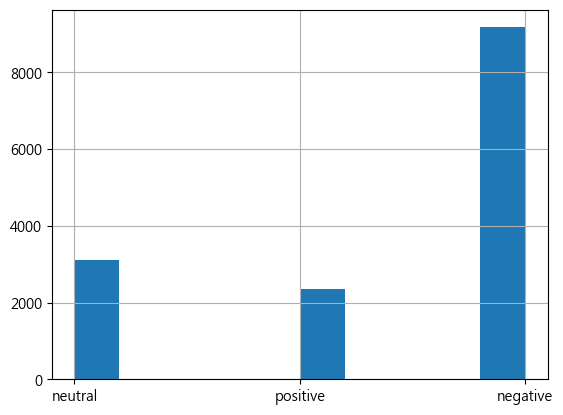

In [41]:
df['airline_sentiment'].hist()

In [42]:
df = df[df['airline_sentiment'] != 'neutral'].copy()

In [43]:
target_map = {'positive': 1, 'negative': 0}
df['target'] = df['airline_sentiment'].map(target_map)

In [44]:
df_train, df_test = train_test_split(df, random_state=42)


In [66]:
print(len(df_train), len(df_test),len(df_train)/len(df_test))

8655 2886 2.998960498960499


In [45]:
vectorizer = TfidfVectorizer(max_features=2000)
X_train = vectorizer.fit_transform(df_train['text'])
X_test = vectorizer.transform(df_test['text'])

In [46]:
# data must not be sparse matrix before passing into tensorflow
X_train = X_train.toarray()
X_test = X_test.toarray()

In [47]:
Y_train = df_train['target']
Y_test = df_test['target']

In [48]:
# input dimensions
D = X_train.shape[1]

In [71]:
model = keras.Sequential([
    layers.Input(shape=(D,)),  # 输入层
    # layers.Dense(2, activation = "sigmoid"),  # 输出层，sigmoid included in loss
    layers.Dense(1)  # 输出层，sigmoid included in loss
])

# 编译模型
model.compile(optimizer=Adam(learning_rate=0.01), loss=BinaryCrossentropy(from_logits=True), metrics=['accuracy'])


# 打印模型参数
model.summary()

# 训练模型，并同时记录训练集和测试集的损失和准确度
history = model.fit(X_train, Y_train, epochs=40, verbose=1, validation_data=(X_test, Y_test), batch_size=128)



Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1)                 2001      
                                                                 
Total params: 2,001
Trainable params: 2,001
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
68/68 [==============================] - 1s 7ms/step - loss: 0.5038 - accuracy: 0.7920 - val_loss: 0.3977 - val_accuracy: 0.8049
Epoch 2/40
68/68 [==============================] - 0s 3ms/step - loss: 0.3762 - accuracy: 0.7963 - val_loss: 0.3395 - val_accuracy: 0.8209
Epoch 3/40
68/68 [==============================] - 0s 3ms/step - loss: 0.3225 - accuracy: 0.8180 - val_loss: 0.3028 - val_accuracy: 0.8413
Epoch 4/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2852 - accuracy: 0.8451 - val_loss: 0.2769 - val_accuracy: 0.8593
Epoch 5/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2577 - accuracy: 0.8639 - val_loss: 0.2582 - val_accuracy: 0.8777
Epoch 6/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2368 - accuracy: 0.8808 - val_loss: 0.2444 - val_accuracy: 0.8888
Epoch 7/40
68/68 [==============================] - 0s 3ms/step - loss: 0.2203 - accuracy: 0.8928 - val_loss: 0.2335 - val_accuracy: 0.9006
Epoch 8/40
68/68 [==

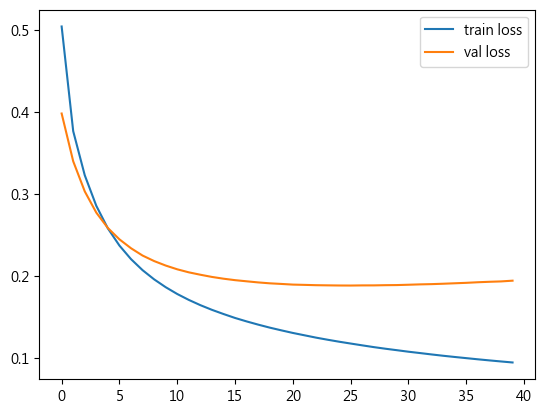

In [72]:
# Plot loss per iteration
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

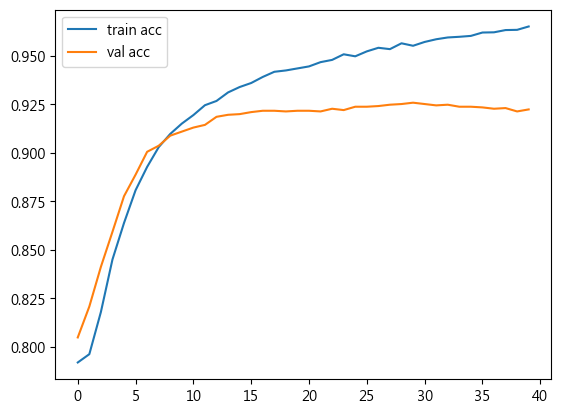

In [73]:
# Plot accuracy per iteration
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

In [52]:
P_train = ((model.predict(X_train) > 0) * 1.0).flatten()
P_test = ((model.predict(X_test) > 0) * 1.0).flatten()

91/91 [==============================] - 0s 2ms/step


In [53]:
cm = confusion_matrix(Y_train, P_train, normalize='true')
cm

array([[0.99110139, 0.00889861],
       [0.09833333, 0.90166667]])

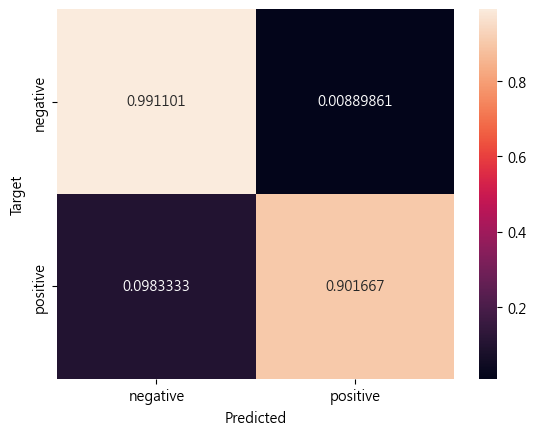

In [54]:
# Scikit-Learn is transitioning to V1 but it's not available on Colab
# The changes modify how confusion matrices are plotted
def plot_cm(cm):
  classes = ['negative', 'positive']
  df_cm = pd.DataFrame(cm, index=classes, columns=classes)
  ax = sn.heatmap(df_cm, annot=True, fmt='g')
  ax.set_xlabel("Predicted")
  ax.set_ylabel("Target")

plot_cm(cm)

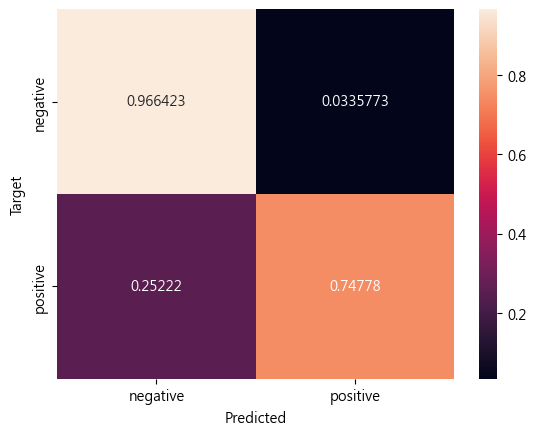

In [55]:
cm_test = confusion_matrix(Y_test, P_test, normalize='true')
plot_cm(cm_test)

In [56]:
Pr_train = model.predict(X_train)
Pr_test = model.predict(X_test)
print("Train AUC:", roc_auc_score(Y_train, Pr_train))
print("Test AUC:", roc_auc_score(Y_test, Pr_test))

91/91 [==============================] - 0s 2ms/step
Train AUC: 0.995009563173677
Test AUC: 0.9547715370811156


Train ROC AUC: 0.995009563173677


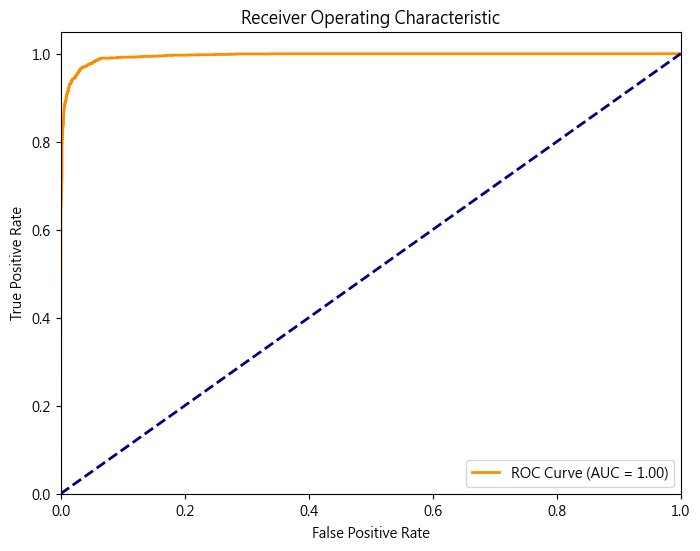

In [57]:
# 计算 ROC 曲线数据点
fpr, tpr, _ = roc_curve(Y_train, Pr_train)

# 计算 AUC
roc_auc = auc(fpr, tpr)
print("Train ROC AUC:", roc_auc)

# 绘制 ROC 曲线
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()



In [58]:
confusion_train = confusion_matrix(Y_train, P_train)

TP = confusion_train[1, 1]  
FP = confusion_train[0, 1]  
FN = confusion_train[1, 0]

precision = TP / (TP + FP)
print("Train Precision:", precision)

recall = TP / (TP + FN) 
print("Train Recall:", recall) 

confusion_test = confusion_matrix(Y_test, P_test)

TP = confusion_test[1, 1]  
FP = confusion_test[0, 1]  
FN = confusion_test[1, 0]

precision = TP / (TP + FP)
print("Test Precision:", precision)

recall = TP / (TP + FN) 
print("Test Recall:", recall)  


Train Precision: 0.9637767220902613
Train Recall: 0.9016666666666666
Test Precision: 0.843687374749499
Test Recall: 0.7477797513321492


In [59]:
print("Train F1:", f1_score(Y_train, P_train))
print("Test F1:", f1_score(Y_test, P_test))


Train F1: 0.9316877152698048
Test F1: 0.792843691148776


In [60]:
model.layers

In [61]:
model.layers[0].get_weights()

[array([[-3.7631106],
        [ 3.2980354],
        [-1.5748787],
        ...,
        [ 2.049774 ],
        [ 1.6356052],
        [-2.92814  ]], dtype=float32),
 array([-0.24720359], dtype=float32)]

In [62]:
w = model.layers[0].get_weights()[0]

In [63]:
word_index_map = vectorizer.vocabulary_
word_index_map

{'jetblue': 973,
 'thanks': 1726,
 'for': 753,
 'having': 855,
 'us': 1859,
 'hang': 838,
 'out': 1262,
 'at': 197,
 'tampa': 1708,
 'airport': 122,
 'forever': 756,
 'today': 1767,
 'it': 964,
 'really': 1420,
 'been': 243,
 'an': 147,
 'awesome': 217,
 'experience': 654,
 'americanair': 143,
 'was': 1898,
 'told': 1770,
 'you': 1993,
 'could': 452,
 'only': 1245,
 'refund': 1434,
 'me': 1107,
 'the': 1730,
 'cost': 448,
 'of': 1224,
 'my': 1179,
 'original': 1254,
 'return': 1476,
 'flight': 726,
 'note': 1211,
 'had': 828,
 'booked': 273,
 'more': 1164,
 'expensive': 653,
 'everyone': 635,
 'else': 602,
 'outstanding': 1267,
 'united': 1842,
 'denver': 516,
 'to': 1766,
 'austin': 207,
 'still': 1660,
 'on': 1239,
 'ground': 820,
 'issue': 961,
 'is': 959,
 'lack': 999,
 'announcement': 151,
 'made': 1086,
 'so': 1606,
 'late': 1010,
 'when': 1929,
 'gate': 793,
 'agent': 113,
 'there': 1734,
 'over': 1268,
 'hour': 897,
 'southwestair': 1626,
 'hold': 880,
 '30': 36,
 'min': 1141,


In [64]:
# let's look at the weights for each word
# try it with different threshold values!
threshold = 2

print("Most positive words:")
word_weight_tuples = []
for word, index in word_index_map.items():
    weight = w[index, 0]
    if weight > threshold:
        word_weight_tuples.append((word, weight))

word_weight_tuples = sorted(word_weight_tuples, key=lambda x: -x[1])
for i in range(10):
  word, weight = word_weight_tuples[i]
  print(word, weight)

Most positive words:
thank 9.7623415
thanks 9.411463
worries 8.377937
great 7.9342127
awesome 7.3708982
love 7.246859
excellent 7.135802
kudos 6.7075043
amazing 6.4833984
best 6.1098685
